### MMDetection 설치
* 강의 영상에는 pip install mmcv-full로 mmcv를 설치(약 10분 정도의 시간이 소요)
* 실습코드는 pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu116/torch1.13/index.html 로 변경(설치에 12초 정도 걸림. 2022.09).
* 코랩의 pytorch 버전이 2.0으로 upgrade되었으나 mmdetection은 아직 pytorch 2.0을 지원하지 않기에 pytorch 1.13으로 downgrade 필요(2023.04월에 코랩 pytorch upgrade)
*  2023년 4월 6일 기준으로 mmdetection이 3.0으로 upgrade됨. 실습 코드는 mmdetection 2.x 기준으므로 mmdetection 2.x 소스코드 설치 필요. 

In [ ]:
#코랩의 pytorch 버전이 2.0으로 upgrade됨. 
import torch
print(torch.__version__)

1.12.1+cu113


In [ ]:
#현재 mmdetection이 pytorch 2.x를 지원하지 않음. pytorch 1.13+ CUDA 116 환경으로 코랩 커널 downgrade
# downgrade 설치시 ERROR: pip's dependency resolver... 부분은 신경쓰지 않아도 됨. 
!pip install torch==1.13.0+cu116 torchvision==0.14.0+cu116 --extra-index-url https://download.pytorch.org/whl/cu116

In [ ]:
# mmcv를 위해서 mmcv-full을 먼저 설치해야 함. https://mmcv.readthedocs.io/en/latest/get_started/installation.html 설치 과정 참조.
!pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu116/torch1.13/index.html

In [ ]:
# 2023년 4월 6일 기준으로 mmdetection이 3.0으로 upgrade됨. 실습 코드는 mmdetection 2.x 기준임. 
# mmdetection 2.x branch의 소스코드 기반으로 mmdetection 설치 필요. 
!git clone --branch 2.x https://github.com/open-mmlab/mmdetection.git
!cd mmdetection; python setup.py install

In [ ]:
# 아래를 수행하기 전에 kernel을 restart 해야 함. 
from mmdet.apis import init_detector, inference_detector
import mmcv

### PASCAL VOC형태의 BCCD Dataset를 Download 후 MS-COCO 형태로 변경
* BCCD Dataset은 백혈구(WBC), 적혈구(RBC), 혈소판(Platelets) 세가지 유형의 Object Class를 가짐.
* 다운로드 받은 Dataset은 Pascal VOC 형태이므로 이를 별도의 유틸리티를 이용하여 MS-COCO 형태로 변환 


In [ ]:
!git clone https://github.com/Shenggan/BCCD_Dataset.git

fatal: destination path 'BCCD_Dataset' already exists and is not an empty directory.


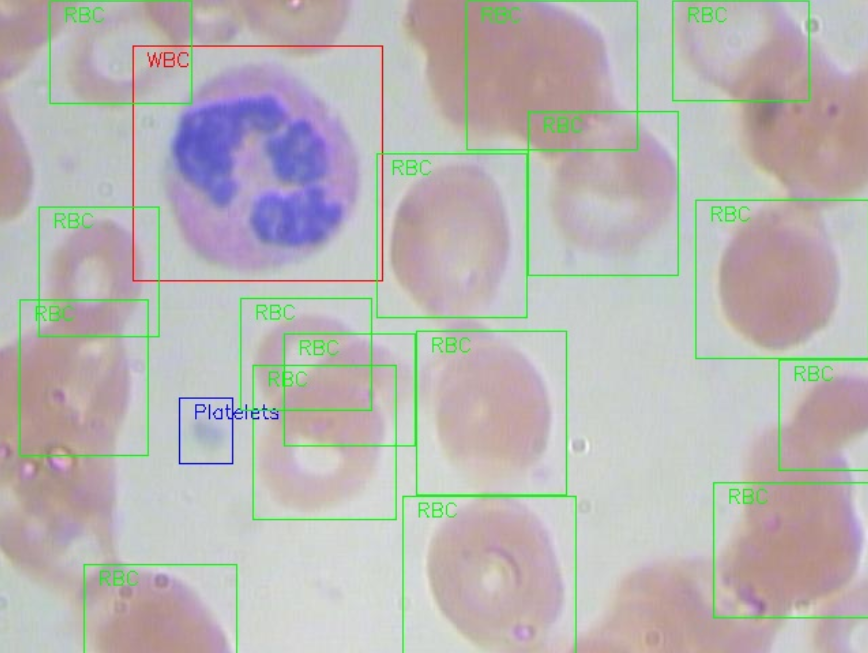

### VOC를 COCO로 변환하는 package적용하기

In [ ]:
!git clone https://github.com/yukkyo/voc2coco.git

fatal: destination path 'voc2coco' already exists and is not an empty directory.


In [ ]:
import os

# colab 버전은 아래 명령어로 ballnfish_classes.txt 를 수정합니다. 
with open('/content/BCCD_Dataset/BCCD/labels.txt', "w") as f:
    f.write("WBC\n")
    f.write("RBC\n")
    f.write("Platelets\n")

!cat /content/BCCD_Dataset/BCCD/labels.txt

WBC
RBC
Platelets


In [ ]:
# VOC를 COCO로 변환 수행. 학습/검증/테스트 용 json annotation을 생성. 
%cd voc2coco
!python voc2coco.py --ann_dir /content/BCCD_Dataset/BCCD/Annotations \
--ann_ids /content/BCCD_Dataset/BCCD/ImageSets/Main/train.txt \
--labels /content/BCCD_Dataset/BCCD/labels.txt \
--output /content/BCCD_Dataset/BCCD/train.json \
--ext xml

!python voc2coco.py --ann_dir /content/BCCD_Dataset/BCCD/Annotations \
--ann_ids /content/BCCD_Dataset/BCCD/ImageSets/Main/val.txt \
--labels /content/BCCD_Dataset/BCCD/labels.txt \
--output /content/BCCD_Dataset/BCCD/val.json \
--ext xml

!python voc2coco.py --ann_dir /content/BCCD_Dataset/BCCD/Annotations \
--ann_ids /content/BCCD_Dataset/BCCD/ImageSets/Main/test.txt \
--labels /content/BCCD_Dataset/BCCD/labels.txt \
--output /content/BCCD_Dataset/BCCD/test.json \
--ext xml

/content/voc2coco
Start converting !
100% 205/205 [00:00<00:00, 5275.63it/s]
Start converting !
100% 87/87 [00:00<00:00, 5539.35it/s]
Start converting !
100% 72/72 [00:00<00:00, 5470.63it/s]


In [ ]:
!cat /content/BCCD_Dataset/BCCD/train.json

{"images": [{"file_name": "BloodImage_00001.jpg", "height": 480, "width": 640, "id": "BloodImage_00001"}, {"file_name": "BloodImage_00003.jpg", "height": 480, "width": 640, "id": "BloodImage_00003"}, {"file_name": "BloodImage_00004.jpg", "height": 480, "width": 640, "id": "BloodImage_00004"}, {"file_name": "BloodImage_00005.jpg", "height": 480, "width": 640, "id": "BloodImage_00005"}, {"file_name": "BloodImage_00006.jpg", "height": 480, "width": 640, "id": "BloodImage_00006"}, {"file_name": "BloodImage_00008.jpg", "height": 480, "width": 640, "id": "BloodImage_00008"}, {"file_name": "BloodImage_00009.jpg", "height": 480, "width": 640, "id": "BloodImage_00009"}, {"file_name": "BloodImage_00010.jpg", "height": 480, "width": 640, "id": "BloodImage_00010"}, {"file_name": "BloodImage_00012.jpg", "height": 480, "width": 640, "id": "BloodImage_00012"}, {"file_name": "BloodImage_00013.jpg", "height": 480, "width": 640, "id": "BloodImage_00013"}, {"file_name": "BloodImage_00020.jpg", "height": 

In [ ]:
# annotation json 파일을 잘 볼수 있는 jq 유틸리티 셋업. 
!sudo apt-get install jq

Reading package lists... Done
Building dependency tree       
Reading state information... Done
jq is already the newest version (1.5+dfsg-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.


In [ ]:
!jq . /content/BCCD_Dataset/BCCD/train.json > output.json
!tail -100 output.json

      "category_id": 2,
      "ignore": 0,
      "segmentation": [],
      "image_id": "BloodImage_00408",
      "id": 2800
    },
    {
      "area": 9405,
      "iscrowd": 0,
      "bbox": [
        102,
        0,
        99,
        95
      ],
      "category_id": 2,
      "ignore": 0,
      "segmentation": [],
      "image_id": "BloodImage_00408",
      "id": 2801
    },
    {
      "area": 7128,
      "iscrowd": 0,
      "bbox": [
        197,
        0,
        88,
        81
      ],
      "category_id": 2,
      "ignore": 0,
      "segmentation": [],
      "image_id": "BloodImage_00408",
      "id": 2802
    },
    {
      "area": 756,
      "iscrowd": 0,
      "bbox": [
        0,
        280,
        21,
        36
      ],
      "category_id": 3,
      "ignore": 0,
      "segmentation": [],
      "image_id": "BloodImage_00408",
      "id": 2803
    },
    {
      "area": 1302,
      "iscrowd": 0,
      "bbox": [
        382,
        253,
        42,
        31
      ],
   

In [ ]:
!jq . /content/BCCD_Dataset/BCCD/test.json > output.json
!cat output.json

{
  "images": [
    {
      "file_name": "BloodImage_00007.jpg",
      "height": 480,
      "width": 640,
      "id": "BloodImage_00007"
    },
    {
      "file_name": "BloodImage_00011.jpg",
      "height": 480,
      "width": 640,
      "id": "BloodImage_00011"
    },
    {
      "file_name": "BloodImage_00015.jpg",
      "height": 480,
      "width": 640,
      "id": "BloodImage_00015"
    },
    {
      "file_name": "BloodImage_00016.jpg",
      "height": 480,
      "width": 640,
      "id": "BloodImage_00016"
    },
    {
      "file_name": "BloodImage_00018.jpg",
      "height": 480,
      "width": 640,
      "id": "BloodImage_00018"
    },
    {
      "file_name": "BloodImage_00019.jpg",
      "height": 480,
      "width": 640,
      "id": "BloodImage_00019"
    },
    {
      "file_name": "BloodImage_00021.jpg",
      "height": 480,
      "width": 640,
      "id": "BloodImage_00021"
    },
    {
      "file_name": "BloodImage_00031.jpg",
      "height": 480,
      "width": 640

### CocoDataset 클래스를 활용하여 BCCD Dataset을 로딩하기
* MS-COCO Dataset의 경우 별다른 Custom Code없이 Object들의 Class만 지정해 주면 됨

In [ ]:
%cd /content

/content


In [ ]:
from mmdet.datasets.builder import DATASETS
from mmdet.datasets.coco import CocoDataset

@DATASETS.register_module(force=True)
class BCCDDataset(CocoDataset):
  CLASSES = ('WBC', 'RBC', 'Platelets') 

### Config 설정하고 Checkpoint 파일 다운로드 받기

In [ ]:
config_file = '/content/mmdetection/configs/faster_rcnn/faster_rcnn_r50_fpn_1x_coco.py'
checkpoint_file = '/content/mmdetection/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth'

In [ ]:
!pwd

/content


In [ ]:
!cd /content/mmdetection; mkdir checkpoints
!wget -O /content/mmdetection/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth http://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth

mkdir: cannot create directory ‘checkpoints’: File exists
--2022-08-26 07:54:00--  http://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.254.187.167
Connecting to download.openmmlab.com (download.openmmlab.com)|47.254.187.167|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 167287506 (160M) [application/octet-stream]
Saving to: ‘/content/mmdetection/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth’

/content/mmdetectio 100%[===================>] 159.54M  10.1MB/s    in 16s     

2022-08-26 07:54:17 (10.1 MB/s) - ‘/content/mmdetection/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth’ saved [167287506/167287506]



In [ ]:
!ls -lia /content/mmdetection/checkpoints

total 163376
5248204 drwxr-xr-x  2 root root      4096 Aug 26 07:42 .
5242886 drwxr-xr-x 19 root root      4096 Aug 26 07:42 ..
5248205 -rw-r--r--  1 root root 167287506 Nov  2  2021 faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth


In [ ]:
from mmcv import Config

cfg = Config.fromfile(config_file)
print(cfg.pretty_text)

model = dict(
    type='FasterRCNN',
    backbone=dict(
        type='ResNet',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=True,
        style='pytorch',
        init_cfg=dict(type='Pretrained', checkpoint='torchvision://resnet50')),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[8],
            ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[0.0, 0.0, 0.0, 0.0],
            target_stds=[1.0, 1.0, 1.0, 1.0]),
        loss_cls=dict(
            type='CrossEntropyLoss', use_sigmoid=True, loss_weight=1.

In [ ]:
from mmdet.apis import set_random_seed

# dataset에 대한 환경 파라미터 수정. 
cfg.dataset_type = 'BCCDDataset'
cfg.data_root = '/content/BCCD_Dataset/BCCD/'

# train, val, test dataset에 대한 type, data_root, ann_file, img_prefix 환경 파라미터 수정. 
cfg.data.train.type = 'BCCDDataset'
cfg.data.train.data_root = '/content/BCCD_Dataset/BCCD/'
cfg.data.train.ann_file = 'train.json'
cfg.data.train.img_prefix = 'JPEGImages'

cfg.data.val.type = 'BCCDDataset'
cfg.data.val.data_root = '/content/BCCD_Dataset/BCCD/'
cfg.data.val.ann_file = 'val.json'
cfg.data.val.img_prefix = 'JPEGImages'

cfg.data.test.type = 'BCCDDataset'
cfg.data.test.data_root = '/content/BCCD_Dataset/BCCD/'
cfg.data.test.ann_file = 'test.json'
cfg.data.test.img_prefix = 'JPEGImages'

# class의 갯수 수정. 
cfg.model.roi_head.bbox_head.num_classes = 3
# pretrained 모델
cfg.load_from = '/content/mmdetection/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth'

# 학습 weight 파일로 로그를 저장하기 위한 디렉토리 설정. 
cfg.work_dir = './tutorial_exps'

# 학습율 변경 환경 파라미터 설정. 
cfg.optimizer.lr = 0.02 / 8
cfg.lr_config.warmup = None
cfg.log_config.interval = 10

# CocoDataset의 경우 metric을 bbox로 설정해야 함.(mAP아님. bbox로 설정하면 mAP를 iou threshold를 0.5 ~ 0.95까지 변경하면서 측정)
cfg.evaluation.metric = 'bbox'
cfg.evaluation.interval = 12
cfg.checkpoint_config.interval = 12

# 두번 config를 로드하면 lr_config의 policy가 사라지는 오류로 인하여 설정. 
cfg.lr_config.policy='step'
# Set seed thus the results are more reproducible
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)
# ConfigDict' object has no attribute 'device 오류 발생시 반드시 설정 필요. https://github.com/open-mmlab/mmdetection/issues/7901
cfg.device='cuda'

In [ ]:
print(cfg.pretty_text)

model = dict(
    type='FasterRCNN',
    backbone=dict(
        type='ResNet',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=True,
        style='pytorch',
        init_cfg=dict(type='Pretrained', checkpoint='torchvision://resnet50')),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[8],
            ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[0.0, 0.0, 0.0, 0.0],
            target_stds=[1.0, 1.0, 1.0, 1.0]),
        loss_cls=dict(
            type='CrossEntropyLoss', use_sigmoid=True, loss_weight=1.

### Dataset을 만들고, 모델 학습 및 Inference 적용

In [ ]:
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector

# train용 Dataset 생성. 
datasets = [build_dataset(cfg.data.train)]

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


In [ ]:
print(datasets[0])
# datasets[0].__dict__ 로 모든 self variables의 key와 value값을 볼 수 있음. 
datasets[0].__dict__.keys()


BCCDDataset Train dataset with number of images 205, and instance counts: 
+----------+-------+----------+-------+---------------+-------+----------+-------+----------+-------+
| category | count | category | count | category      | count | category | count | category | count |
+----------+-------+----------+-------+---------------+-------+----------+-------+----------+-------+
|          |       |          |       |               |       |          |       |          |       |
| 0 [WBC]  | 214   | 1 [RBC]  | 2382  | 2 [Platelets] | 209   |          |       |          |       |
+----------+-------+----------+-------+---------------+-------+----------+-------+----------+-------+


dict_keys(['ann_file', 'data_root', 'img_prefix', 'seg_prefix', 'proposal_file', 'test_mode', 'filter_empty_gt', 'file_client', 'CLASSES', 'coco', 'cat_ids', 'cat2label', 'img_ids', 'data_infos', 'proposals', 'flag', 'pipeline'])

In [ ]:
datasets[0].data_infos

[{'file_name': 'BloodImage_00001.jpg',
  'height': 480,
  'width': 640,
  'id': 'BloodImage_00001',
  'filename': 'BloodImage_00001.jpg'},
 {'file_name': 'BloodImage_00003.jpg',
  'height': 480,
  'width': 640,
  'id': 'BloodImage_00003',
  'filename': 'BloodImage_00003.jpg'},
 {'file_name': 'BloodImage_00004.jpg',
  'height': 480,
  'width': 640,
  'id': 'BloodImage_00004',
  'filename': 'BloodImage_00004.jpg'},
 {'file_name': 'BloodImage_00005.jpg',
  'height': 480,
  'width': 640,
  'id': 'BloodImage_00005',
  'filename': 'BloodImage_00005.jpg'},
 {'file_name': 'BloodImage_00006.jpg',
  'height': 480,
  'width': 640,
  'id': 'BloodImage_00006',
  'filename': 'BloodImage_00006.jpg'},
 {'file_name': 'BloodImage_00008.jpg',
  'height': 480,
  'width': 640,
  'id': 'BloodImage_00008',
  'filename': 'BloodImage_00008.jpg'},
 {'file_name': 'BloodImage_00009.jpg',
  'height': 480,
  'width': 640,
  'id': 'BloodImage_00009',
  'filename': 'BloodImage_00009.jpg'},
 {'file_name': 'BloodImage_

In [ ]:
datasets[0].pipeline

Compose(
    LoadImageFromFile(to_float32=False, color_type='color', channel_order='bgr', file_client_args={'backend': 'disk'})
    LoadAnnotations(with_bbox=True, with_label=True, with_mask=False, with_seg=False, poly2mask=True, file_client_args={'backend': 'disk'})
    Resize(img_scale=[(1333, 800)], multiscale_mode=range, ratio_range=None, keep_ratio=True, bbox_clip_border=True)
    RandomFlip(flip_ratio=0.5)
    Normalize(mean=[123.675 116.28  103.53 ], std=[58.395 57.12  57.375], to_rgb=True)
    Pad(size=None, size_divisor=32, pad_to_square=False, pad_val={'img': 0, 'masks': 0, 'seg': 255})
    DefaultFormatBundle(img_to_float=True)
    Collect(keys=['img', 'gt_bboxes', 'gt_labels'], meta_keys=('filename', 'ori_filename', 'ori_shape', 'img_shape', 'pad_shape', 'scale_factor', 'flip', 'flip_direction', 'img_norm_cfg'))
)

In [ ]:
model = build_detector(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
model.CLASSES = datasets[0].CLASSES
print(model.CLASSES)

('WBC', 'RBC', 'Platelets')


In [ ]:
import os.path as osp
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
# epochs는 config의 runner 파라미터로 지정됨. 기본 12회 
train_detector(model, datasets, cfg, distributed=False, validate=True)

2022-08-26 07:54:43,951 - mmdet - INFO - Automatic scaling of learning rate (LR) has been disabled.
2022-08-26 07:54:43,967 - mmdet - INFO - load checkpoint from local path: /content/mmdetection/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth
2022-08-26 07:54:44,095 - mmdet - WARNING - The model and loaded state dict do not match exactly

size mismatch for roi_head.bbox_head.fc_cls.weight: copying a param with shape torch.Size([81, 1024]) from checkpoint, the shape in current model is torch.Size([4, 1024]).
size mismatch for roi_head.bbox_head.fc_cls.bias: copying a param with shape torch.Size([81]) from checkpoint, the shape in current model is torch.Size([4]).
size mismatch for roi_head.bbox_head.fc_reg.weight: copying a param with shape torch.Size([320, 1024]) from checkpoint, the shape in current model is torch.Size([12, 1024]).
size mismatch for roi_head.bbox_head.fc_reg.bias: copying a param with shape torch.Size([320]) from checkpoint, the shape in current model is

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


2022-08-26 07:54:50,568 - mmdet - INFO - Epoch [1][10/103]	lr: 2.500e-03, eta: 0:13:01, time: 0.637, data_time: 0.228, memory: 3162, loss_rpn_cls: 0.1531, loss_rpn_bbox: 0.0884, loss_cls: 0.8340, acc: 66.1328, loss_bbox: 0.8048, loss: 1.8804
2022-08-26 07:54:53,603 - mmdet - INFO - Epoch [1][20/103]	lr: 2.500e-03, eta: 0:09:32, time: 0.303, data_time: 0.016, memory: 3162, loss_rpn_cls: 0.0345, loss_rpn_bbox: 0.0673, loss_cls: 0.4867, acc: 84.3750, loss_bbox: 0.6139, loss: 1.2024
2022-08-26 07:54:56,647 - mmdet - INFO - Epoch [1][30/103]	lr: 2.500e-03, eta: 0:08:20, time: 0.304, data_time: 0.015, memory: 3162, loss_rpn_cls: 0.0174, loss_rpn_bbox: 0.0716, loss_cls: 0.3837, acc: 86.2695, loss_bbox: 0.5021, loss: 0.9748
2022-08-26 07:54:59,671 - mmdet - INFO - Epoch [1][40/103]	lr: 2.500e-03, eta: 0:07:42, time: 0.302, data_time: 0.015, memory: 3162, loss_rpn_cls: 0.0243, loss_rpn_bbox: 0.0788, loss_cls: 0.3537, acc: 85.8691, loss_bbox: 0.4454, loss: 0.9023
2022-08-26 07:55:02,686 - mmdet 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 87/87, 13.6 task/s, elapsed: 6s, ETA:     0s

2022-08-26 08:01:38,980 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2022-08-26 08:01:39,667 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.628
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.900
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.713
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.148
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.501
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.731
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.716
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.716
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.716
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.150
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.636
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.60s).
Accumulating evaluation results...
DONE (t=0.07s).


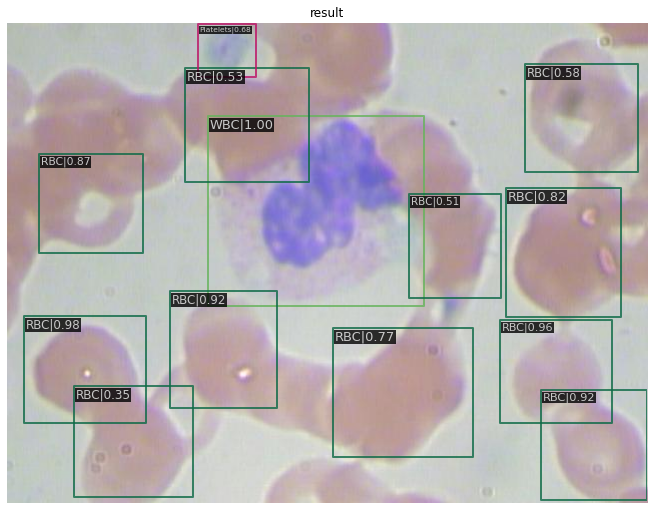

In [ ]:
import cv2
from mmdet.apis import inference_detector, init_detector, show_result_pyplot

img = cv2.imread('/content/BCCD_Dataset/BCCD/JPEGImages/BloodImage_00007.jpg')

model.cfg = cfg

result = inference_detector(model, img)
show_result_pyplot(model, img, result)

### 테스트 데이터 세트에 Inference 및 Evaluation 적용하기
* 런타임 다시 시작 수행 필요(버그?)
* tools/test.py 스크립트는 colab에서 오류 발생
* 테스트용 Dataset과 DataLoader생성하고 single_gpu_test()를 호출하여 inference 결과를 반환. batch_size를 1로 설정하지 않으면 single_gpu_test() 오류 발생. 

In [ ]:
### 아래는 런타임 다시 시작 후 실행

from mmcv import Config
from mmdet.datasets.builder import DATASETS
from mmdet.datasets.coco import CocoDataset
from mmdet.apis import set_random_seed

@DATASETS.register_module(force=True)
class BCCDDataset(CocoDataset):
  CLASSES = ('WBC', 'RBC', 'Platelets') 

config_file = '/content/mmdetection/configs/faster_rcnn/faster_rcnn_r50_fpn_1x_coco.py'
checkpoint_file = '/content/mmdetection/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth'

cfg = Config.fromfile(config_file)

# dataset에 대한 환경 파라미터 수정. 
cfg.dataset_type = 'BCCDDataset'
cfg.data_root = '/content/BCCD_Dataset/BCCD/'

# train, val, test dataset에 대한 type, data_root, ann_file, img_prefix 환경 파라미터 수정. 
cfg.data.train.type = 'BCCDDataset'
cfg.data.train.data_root = '/content/BCCD_Dataset/BCCD/'
cfg.data.train.ann_file = 'train.json'
cfg.data.train.img_prefix = 'JPEGImages'

cfg.data.val.type = 'BCCDDataset'
cfg.data.val.data_root = '/content/BCCD_Dataset/BCCD/'
cfg.data.val.ann_file = 'val.json'
cfg.data.val.img_prefix = 'JPEGImages'

cfg.data.test.type = 'BCCDDataset'
cfg.data.test.data_root = '/content/BCCD_Dataset/BCCD/'
cfg.data.test.ann_file = 'test.json'
cfg.data.test.img_prefix = 'JPEGImages'

# class의 갯수 수정. 
cfg.model.roi_head.bbox_head.num_classes = 3
# pretrained 모델
cfg.load_from = '/content/mmdetection/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth'

# 학습 weight 파일로 로그를 저장하기 위한 디렉토리 설정. 
cfg.work_dir = './tutorial_exps'

# 학습율 변경 환경 파라미터 설정. 
cfg.optimizer.lr = 0.02 / 8
cfg.lr_config.warmup = None
cfg.log_config.interval = 10

# CocoDataset의 경우 metric을 bbox로 설정해야 함.(mAP아님. bbox로 설정하면 mAP를 iou threshold를 0.5 ~ 0.95까지 변경하면서 측정)
cfg.evaluation.metric = 'bbox'
cfg.evaluation.interval = 12
cfg.checkpoint_config.interval = 12

# bug(?)로 인해 test용 dataset evaluation 시 1로 설정. data loader에서 GPU갯수별 Batch size 임. 
cfg.data.samples_per_gpu = 1

# 두번 config를 로드하면 lr_config의 policy가 사라지는 오류로 인하여 설정. 
cfg.lr_config.policy='step'
# Set seed thus the results are more reproducible
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)
print(cfg.pretty_text)

model = dict(
    type='FasterRCNN',
    backbone=dict(
        type='ResNet',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=True,
        style='pytorch',
        init_cfg=dict(type='Pretrained', checkpoint='torchvision://resnet50')),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[8],
            ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[0.0, 0.0, 0.0, 0.0],
            target_stds=[1.0, 1.0, 1.0, 1.0]),
        loss_cls=dict(
            type='CrossEntropyLoss', use_sigmoid=True, loss_weight=1.

In [ ]:
cfg.dump('/content/tutorial_exps/bccd_faster_rcnn_conf.py')

In [ ]:
!mkdir -p /content/show_test_output

In [ ]:
# tools/test.py 는 colab에서 제대로 동작하지 않음. 
%cd /content/mmdetection
!python tools/test.py /content/tutorial_exps/bccd_faster_rcnn_conf.py /content/tutorial_exps/epoch_12.pth \
--eval 'bbox' \
--show-dir /content/show_test_output

/content/mmdetection
/usr/local/lib/python3.7/dist-packages/mmdet-2.25.1-py3.7.egg/mmdet/utils/setup_env.py:39: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting OMP_NUM_THREADS environment variable for each process '
/usr/local/lib/python3.7/dist-packages/mmdet-2.25.1-py3.7.egg/mmdet/utils/setup_env.py:49: UserWarning: Setting MKL_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting MKL_NUM_THREADS environment variable for each process '
Traceback (most recent call last):
  File "tools/test.py", line 275, in <module>
    main()
  File "tools/test.py", line 217, in main
    dataset = build_dataset(cfg.data.test)
  File "/usr/local/lib/python3.7/dist-pa

### 테스트용 dataset와 dataloader를 별도로 설정하고 trained된 checkpoint 모델을 로딩하여 test 수행. 

In [ ]:
from mmdet.datasets import (build_dataloader, build_dataset,
                            replace_ImageToTensor)

# test용 Dataset과 DataLoader 생성. 
# build_dataset()호출 시 list로 감싸지 않는 것이 train용 dataset 생성시와 차이. 
dataset = build_dataset(cfg.data.test)
data_loader = build_dataloader(
        dataset,
        # 반드시 아래 samples_per_gpu 인자값은 1로 설정
        samples_per_gpu=cfg.data.samples_per_gpu,
        workers_per_gpu=cfg.data.workers_per_gpu,
        dist=False,
        shuffle=False)

# 반드시 아래 코드에서 'img' 키값이 tensor로 출력되어야 함. 
next(iter(data_loader))

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


{'img_metas': [DataContainer([[{'filename': '/content/BCCD_Dataset/BCCD/JPEGImages/BloodImage_00007.jpg', 'ori_filename': 'BloodImage_00007.jpg', 'ori_shape': (480, 640, 3), 'img_shape': (800, 1067, 3), 'pad_shape': (800, 1088, 3), 'scale_factor': array([1.6671875, 1.6666666, 1.6671875, 1.6666666], dtype=float32), 'flip': False, 'flip_direction': None, 'img_norm_cfg': {'mean': array([123.675, 116.28 , 103.53 ], dtype=float32), 'std': array([58.395, 57.12 , 57.375], dtype=float32), 'to_rgb': True}}, {'filename': '/content/BCCD_Dataset/BCCD/JPEGImages/BloodImage_00011.jpg', 'ori_filename': 'BloodImage_00011.jpg', 'ori_shape': (480, 640, 3), 'img_shape': (800, 1067, 3), 'pad_shape': (800, 1088, 3), 'scale_factor': array([1.6671875, 1.6666666, 1.6671875, 1.6666666], dtype=float32), 'flip': False, 'flip_direction': None, 'img_norm_cfg': {'mean': array([123.675, 116.28 , 103.53 ], dtype=float32), 'std': array([58.395, 57.12 , 57.375], dtype=float32), 'to_rgb': True}}]])],
 'img': [tensor([[[

In [ ]:
from mmdet.apis import inference_detector, init_detector, show_result_pyplot

checkpoint_file = '/content/tutorial_exps/epoch_12.pth'

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_detector(cfg, checkpoint_file, device='cuda:0')

load checkpoint from local path: /content/tutorial_exps/epoch_12.pth


In [ ]:
from mmdet.apis import multi_gpu_test, single_gpu_test
from mmcv.parallel import MMDataParallel, MMDistributedDataParallel
from mmdet.apis import inference_detector, init_detector, show_result_pyplot

model_ckpt = MMDataParallel(model_ckpt, device_ids=[0])
# single_gpu_test() 를 호출하여 test데이터 세트의 interence 수행. 반드시 batch size는 1이 되어야 함. 
# 위에서 만든 /content/show_test_output 디렉토리에 interence 결과가 시각화된 이미지가 저장됨. 
outputs = single_gpu_test(model_ckpt, data_loader, True, '/content/show_test_output', 0.3)

[                                                  ] 0/72, elapsed: 0s, ETA:

AssertionError: ignored

### batch 크기를 1보다 키우고 테스트 수행 하려면 
* 만일 batch size를 1보다 크게 해서 설정하려면 cfg.data.samples_per_gpu 값을 1보다 크게 설정하고 single_gpu_test() 함수의 bug(?) 코드를 수정 필요. 
* 다시 런타임 다시 시작을 실행 후 config 부터 재 설정후 아래 코드 수행 필요. 여기서는 수행하지 않는 걸로 스킵

In [ ]:
'''
import os.path as osp
import pickle
import shutil
import tempfile
import time

import mmcv
import torch
import torch.distributed as dist
from mmcv.image import tensor2imgs
from mmcv.runner import get_dist_info

def single_gpu_test_batch(model,
                    data_loader,
                    show=False,
                    out_dir=None,
                    show_score_thr=0.3):
    model.eval()
    results = []
    dataset = data_loader.dataset
    prog_bar = mmcv.ProgressBar(len(dataset))
    for i, data in enumerate(data_loader):
        with torch.no_grad():
            result = model(return_loss=False, rescale=True, **data)

        batch_size = len(result)
        if show or out_dir:
            if batch_size == 1 and isinstance(data['img'][0], torch.Tensor):
                img_tensor = data['img'][0]
            else:
                # 아래 코드를 주석 처리 필요. batch_size가 1보다 클때는 data['img'][0].data[0]가 아니라 data['img'][0].data 가 되어야 함. 
                #img_tensor = data['img'][0].data[0]
                # 아래는 버그(?) 수정 코드 
                img_tensor = data['img'][0].data
                print('img_tensor shape2:', img_tensor.shape)
            img_metas = data['img_metas'][0].data[0]
            imgs = tensor2imgs(img_tensor, **img_metas[0]['img_norm_cfg'])
            assert len(imgs) == len(img_metas)

            for i, (img, img_meta) in enumerate(zip(imgs, img_metas)):
                h, w, _ = img_meta['img_shape']
                img_show = img[:h, :w, :]

                ori_h, ori_w = img_meta['ori_shape'][:-1]
                img_show = mmcv.imresize(img_show, (ori_w, ori_h))

                if out_dir:
                    out_file = osp.join(out_dir, img_meta['ori_filename'])
                else:
                    out_file = None

                model.module.show_result(
                    img_show,
                    result[i],
                    show=show,
                    out_file=out_file,
                    score_thr=show_score_thr)

        # encode mask results
        if isinstance(result[0], tuple):
            result = [(bbox_results, encode_mask_results(mask_results))
                      for bbox_results, mask_results in result]
        results.extend(result)

        for _ in range(batch_size):
            prog_bar.update()
    return results

from mmdet.apis import multi_gpu_test, single_gpu_test
from mmcv.parallel import MMDataParallel, MMDistributedDataParallel
from mmdet.apis import inference_detector, init_detector, show_result_pyplot

model_ckpt = MMDataParallel(model_ckpt, device_ids=[0])
# single_gpu_test() 를 호출하여 test데이터 세트의 interence 수행. 반드시 batch size는 1이 되어야 함. 
outputs = single_gpu_test(model_ckpt, data_loader, True, '/content/tutorial_exps', 0.3)
'''


### 반환된 test용 데이터세트의 inference 적용 결과 확인 및 성능 evaluation 수행. 

In [ ]:
print('결과 outputs type:', type(outputs))
print('evalution 된 파일의 갯수:', len(outputs))
print('첫번째 evalutation 결과의 type:', type(outputs[0]))
print('첫번째 evaluation 결과의 CLASS 갯수:', len(outputs[0]))
print('첫번째 evaluation 결과의 CLASS ID 0의 type과 shape', type(outputs[0][0]), outputs[0][0].shape)

In [ ]:
print(outputs)

In [ ]:
metric = dataset.evaluate(outputs, metric='bbox')
print(metric)